<a href="https://colab.research.google.com/github/TA-PP/SKT-FLY-AI/blob/main/Fly_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset and DataLoader

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# Pytorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

In [6]:
# Create datesets for training & vlaidation, download if necesarry
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
# Create data loader for our datasets: shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

In [9]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [11]:
# Report split sizes
print('Trainin set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Trainin set has 60000 instances
Validation set has 10000 instances


### The Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# PyTorch models inherit form torch.nn.Module
class GarmentClassifier(nn.Module):
  def __init__(self):
    super(GarmentClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = GarmentClassifier()

In [14]:
# 손실함수로 CrossEntropyloss 사용
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### The Training Loop

In [18]:
def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0
  last_loss = 0

  # Here, we use enumerate(training_loader) instead of
  # iter(training_loader) so that we can track the batch
  # index and do some intra-epoch reporting
  for i, data in enumerate(training_loader):
    # Every data instance is an input + label pair
    inputs, labels = data

    # zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(inputs)

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather data and report
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000
      print(' batch {} loss: {}'.format(i+1, last_loss))
      tb_x = epoch_index * len(training_loader) + i + 1
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0

    return last_loss

In [20]:
# Initializing in a seperate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
  print('EPOCH {}:'.format(epoch_number + 1))

  # Make sure gradient tracking is on, and do a pass over the data
  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  # We don;t nedd gradients on to do reporting
  model.train(False)

  running_vloss = 0.0
  for i, vdata in enumerate(validation_loader):
    vinputs, vlabels = vdata
    voutputs = model(vinputs)
    vloss = loss_fn(voutputs, vlabels)
    running_vloss += vloss
  
  avg_vloss = running_vloss / (i + 1)
  print('Loss train {} valid {}'.format(avg_loss, avg_vloss))

  # Log the running loss averaged per batch
  # for both training and validation
  writer.add_scalars('Training vs. Validation Loss', {'Training' : avg_loss, 'Validation' : avg_vloss}, epoch_number + 1)
  writer.flush()

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1

EPOCH 1:
Loss train 0 valid 2.3052167892456055
EPOCH 2:
Loss train 0 valid 2.3051815032958984
EPOCH 3:
Loss train 0 valid 2.3051342964172363
EPOCH 4:
Loss train 0 valid 2.3050661087036133
EPOCH 5:
Loss train 0 valid 2.3049893379211426


### Transfer Learning

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

%cd /content/
!unzip -qq /content/hymenoptera_data.zip

--2023-02-16 02:55:55--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.178.40, 99.86.178.33, 99.86.178.43, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.178.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   129MB/s    in 0.3s    

2023-02-16 02:55:56 (129 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

/content


In [3]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 일부 이미지 시각화하기

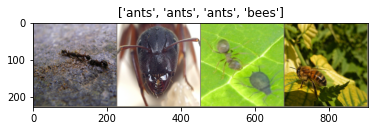

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 모델 학습하기

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

모델 예측값 시각화하기

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 합성곱 신경망 미세조정

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### 학습 및 평가하기

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5241 Acc: 0.7131
val Loss: 0.2664 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.6576 Acc: 0.7869
val Loss: 0.5021 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5299 Acc: 0.7828
val Loss: 0.4993 Acc: 0.7778

Epoch 3/24
----------
train Loss: 0.5867 Acc: 0.7910
val Loss: 0.2607 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.7933 Acc: 0.7213
val Loss: 0.4416 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.5167 Acc: 0.7992
val Loss: 0.2826 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4459 Acc: 0.8074
val Loss: 0.3739 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3699 Acc: 0.8607
val Loss: 0.2712 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3203 Acc: 0.8689
val Loss: 0.2749 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3032 Acc: 0.8811
val Loss: 0.2584 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2765 Acc: 0.9098
val Loss: 0.2330 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3116 Acc: 0.8689
val Loss: 0.2499 Acc: 0.9150

Ep

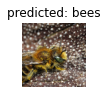

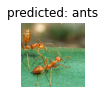

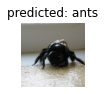

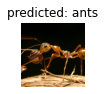

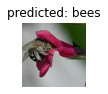

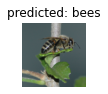

In [9]:
visualize_model(model_ft)

### 고정된 특징 추출기로써의 합성곱 신경망

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 학습 및 평가하기

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6512 Acc: 0.6025
val Loss: 0.2294 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5000 Acc: 0.7623
val Loss: 0.2044 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4884 Acc: 0.7828
val Loss: 0.2010 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5913 Acc: 0.7377
val Loss: 0.1636 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.4538 Acc: 0.8074
val Loss: 0.2065 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4538 Acc: 0.8320
val Loss: 0.1977 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4482 Acc: 0.8402
val Loss: 0.1574 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3626 Acc: 0.8443
val Loss: 0.1642 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3638 Acc: 0.8361
val Loss: 0.2049 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2522 Acc: 0.8893
val Loss: 0.1734 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2410 Acc: 0.9180
val Loss: 0.1540 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3554 Acc: 0.8566
val Loss: 0.1740 Acc: 0.9477

Ep

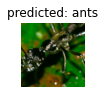

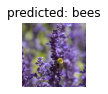

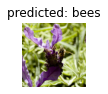

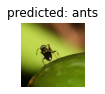

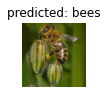

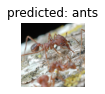

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Batch Normalization

In [16]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
    self.con2 = nn.Conv2d(10, 20, kernel_size=5)
    self.dense1 = nn.Linear(in_features=320, out_features=50)
    self.dense1_bn = nn.BatchNorm1d(50)
    self.dense2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.dense1_bn(self.dense1(x)))
    x = F.relu(self.dense2(x))
    return F.log_softmax(x)

### VGGNet

In [13]:
def conv_2_block(in_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
      nn.MaxPool2d(2,2)
  )
  return model

In [14]:
def conv_3_block(in_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool(2,2)
  )
  return model

In [15]:
class VGG(nn.Module):
  def __init__(self, base_dim, num_classes=10):
    super(VGG, self).__init__()
    self.feature = nn.Sequential(
        conv_2_block(3, base_dim),
        conv_2_block(base_dim, 2*base_dim),
        conv_3_block(2*base_dim, 4*base_dim),
        conv_3_block(4*base_dim, 8*base_dim),
        conv_3_block(8*base_dim, 8*base_dim),
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(8*base_dim*1*1, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 1000),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(1000, num_classes),
    )

    def forward(self, x):
      x = self.feature(x)
      x = x.view(x.size(0), -1)
      x = self.fc_layer(x)
      return x